# EDA

## Структура данных

In [ ]:
import rasterio

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
from glob import glob

pattern = 'data/**/*'
files = glob(pattern, recursive=True)

print(files)

['data\\PNG_original_image_with_mask.png', 'data\\RGB_Polazna_cut.tif', 'data\\TIF_original_image_with_mask&geodata.tif']


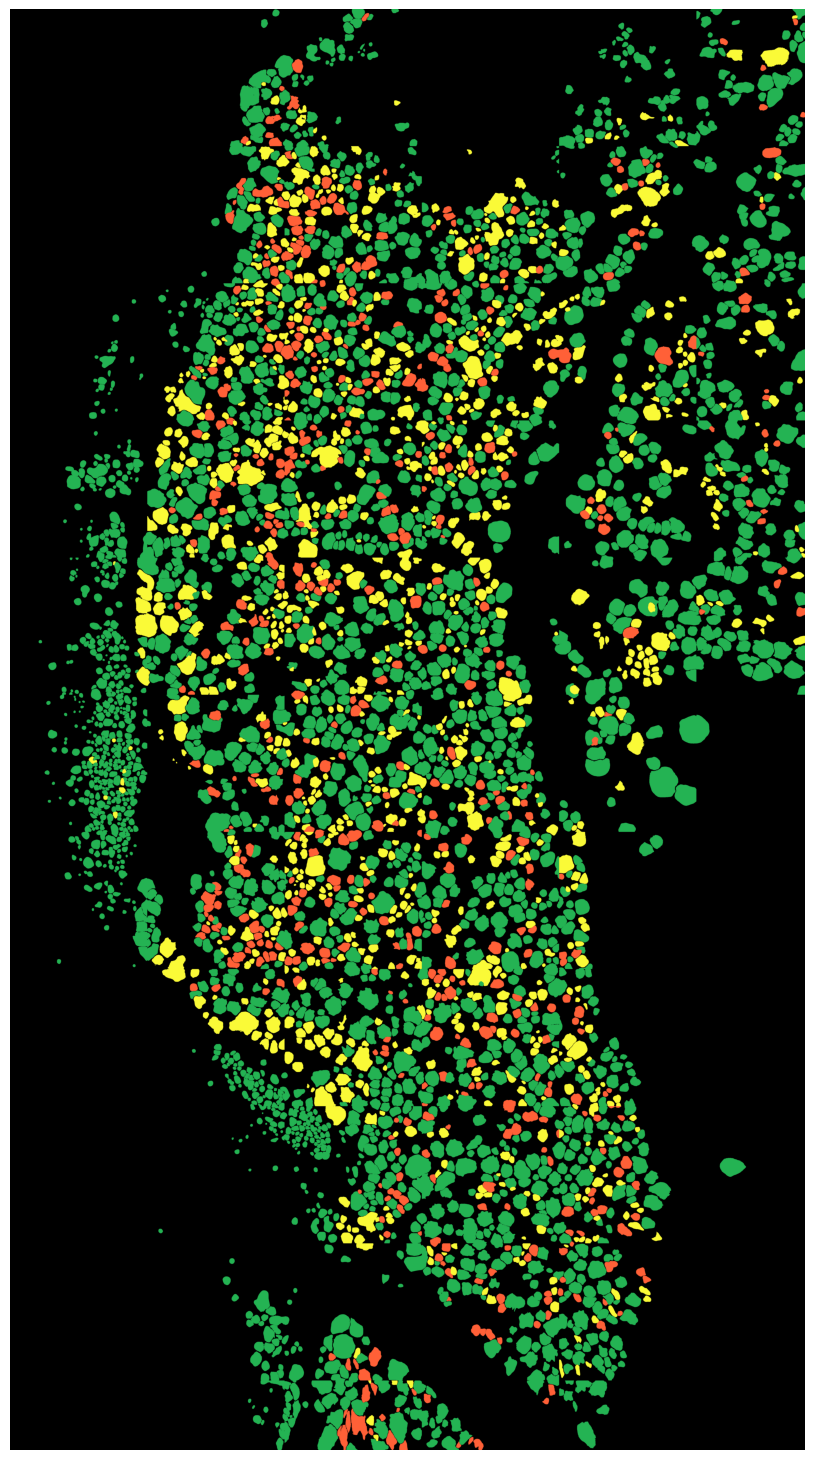

In [12]:
def visualization_images(paths):
    with rasterio.open(path) as src:
        r = src.read(1).astype(np.int16)
        g = src.read(2).astype(np.int16)
        b = src.read(3).astype(np.int16)

        rgb = np.stack([r, g, b], axis=-1)

        fig = plt.figure(figsize=(10, 15))

        plt.imshow(rgb)
        plt.tight_layout()
        plt.axis('off')
        plt.show()


class EDA:
    def __init__(self):
        pass

visualization_images('data/TIF_original_image_with_mask&geodata.tif')

In [11]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

path = 'data/TIF_original_image_with_mask&geodata.tif'

with rasterio.open(path) as src:
    r = src.read(1).astype(np.int16)
    g = src.read(2).astype(np.int16)
    b = src.read(3).astype(np.int16)

    with open('pixels.txt', 'w') as f:
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):
                f.write(str(b[i][j]) + ',' + str(g[i][j]) + ',' + str(r[i][j]) + '\n')
# 55,96,255 -- красный
# 55,250,250 -- желтый
# 83,179,36 -- зеленый

KeyboardInterrupt: 

In [ ]:
import rasterio

path = 'data/RGB_Polazna_cut.tif'

with rasterio.open(path) as src:
    print("✅ Основная информация:")
    print(f"- Ширина: {src.width}")
    print(f"- Высота: {src.height}")
    print(f"- Количество каналов: {src.count}")
    print(f"- Тип данных: {src.dtypes}")  # список по каналам, например ['uint16']
    print(f"- CRS (система координат): {src.crs}")
    print(f"- Transform (геопривязка): {src.transform}")
    print()

    print("🧾 Полные метаданные (src.meta):")
    print(src.meta)


In [3]:
import cv2
import numpy as np
from collections import Counter

def count_pixels_by_color(image):
    color_counts = {
        'red': 0,
        'yellow': 0,
        'green': 0,
        'black': 0
    }

    # Определим цвета в BGR (OpenCV использует BGR)
    colors_bgr = {
        'red':    ([0, 0, 200], [50, 50, 255]),
        'yellow': ([0, 200, 200], [50, 255, 255]),
        'green':  ([0, 150, 0], [90, 255, 50]),
        'black':  ([0, 0, 0], [10, 10, 10])
    }

    for color, (lower, upper) in colors_bgr.items():
        mask = cv2.inRange(image, np.array(lower), np.array(upper))
        count = cv2.countNonZero(mask)
        color_counts[color] = count

    return color_counts

image = cv2.imread('data/PNG_original_image_with_mask.png')
# Подсчёт пикселей
pixel_counts = count_pixels_by_color(image)
print("Pixel counts:", pixel_counts)

Pixel counts: {'red': 0, 'yellow': 0, 'green': 11578458, 'black': 47229678}
